## Exploring parameters and variables

Parameters as assumed being somewhat static. But for certain use-cases (sensitivity analysis, calibration) it might be necessary to
explore the parameter space. This can be achived by 'wrapping', inheriting from a process and implementing parameters (present in parameter toml files) as variables.

In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import xsimlab as xs
import xarray as xr
import vmlab
from vmlab.models import fruit_model

In [2]:
from vmlab.processes.carbon_demand import CarbonDemand

# create a new process and change parameter into variabl
        
@xs.process
class CarbonDemandTest(CarbonDemand):
    RGR_fruit_ini = xs.variable()
    def initialize(self):
        super(CarbonDemandTest, self).initialize()
        # overwrite a parameter from carbon_demand.toml
        self.parameters.RGR_fruit_ini = self.RGR_fruit_ini

In [3]:
fruit_model = fruit_model.update_processes({
    'carbon_demand': CarbonDemandTest
}).drop_processes('fruit_quality')

In [4]:
tree = pd.read_csv('../../vmlab/data/trees/branch_G3.csv')
small_branch = tree[tree.id < 18] # just two fruits

In [5]:
# use a custom weather file
wheater = pd.read_csv(
    '../../vmlab/data/environment/smartis_lingne_paradis_01.2002_01.2008.csv',
    sep=';', parse_dates=['Jour'], dayfirst=True
)
wheater = wheater[wheater.Jour <= '2003-06-01'] # drop some rows
wheater.to_csv('tmp/weather.csv', sep=';')

In [6]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=small_branch,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='fruit_model_branch.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'environment__weather_file': 'tmp/weather.csv'
    },
    output_vars={
        'carbon_allocation__D_fruit': 'day',
        'phenology__fruit_growth_tts_delta': 'day',
        'environment__TM_day': 'day'
    }
)

In [7]:
# change one or more variables and run the model with each set of variables.
# Since the process 'CarbonDemandTest' is declared inside a notebook batch mode, prallelization does not work
RGR_fruit_ini = [x for x in np.linspace(0.0105, 0.0205, 5)]
dss = xr.concat([
    vmlab.run(setup.xsimlab.update_vars(fruit_model, {
        'carbon_demand__RGR_fruit_ini': x
    }), fruit_model) for x in RGR_fruit_ini
], dim=xr.IndexVariable('RGR_fruit_ini', RGR_fruit_ini))
dss

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

<xarray.Dataset>
Dimensions:                            (GU: 18, RGR_fruit_ini: 5, day: 366)
Coordinates:
  * GU                                 (GU) int32 0 1 2 3 4 5 ... 13 14 15 16 17
  * day                                (day) datetime64[ns] 2002-06-01 ... 20...
  * RGR_fruit_ini                      (RGR_fruit_ini) float64 0.0105 ... 0.0205
Data variables:
    carbon_allocation__D_fruit         (RGR_fruit_ini, day, GU) float32 0.0 ....
    environment__TM_day                (RGR_fruit_ini, day) float32 21.92 ......
    phenology__fruit_growth_tts_delta  (RGR_fruit_ini, day, GU) float32 0.0 ....

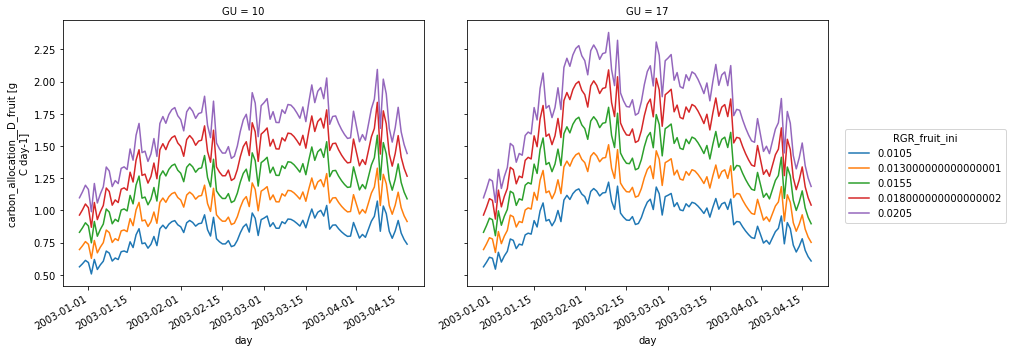

In [8]:
dss.where(dss.carbon_allocation__D_fruit > 0, drop=True).carbon_allocation__D_fruit.plot(hue='RGR_fruit_ini', col='GU', figsize=(12, 5))